# Vision Transformers (ViT)
Lo que hace es básicamente tomar la imagen y dividirla en "parches" y luego de dividirlo lo alimentamos en un encoder transformer y eso hace que las imágenes sean como fichas o tokens para los transformers.

Algo que hay que considerar de esta arquitectura es que junto con las imágenes después de que las aplicamos a la proyección lineal (lineal projection) estamos alimentando las incrustraciones de posición (position embeddings) junto con ellas.

El documento también menciona que hay una clase que se puede aprender que incorpora lo que es, digamos que estamos haciendo una clasificación de oraciones, en lugar de pasar todo el modelo para inferir, almacenamos cada valor en un token al comienzo de la oración que generalmente es un token CLS que en este caso se indica con un \*, toda la información se almacena en este token y solo clasificamos este token. Tenemos un token de incrustración que se puede aprender al principio y que se indica con un * y debemos tener en cuenta que en realidad agrega un token al número total de parches que tenemos, es decir, habrá una cantidad de parches más una incrustación adicional que se pueda aprende.

Otra cosa que necesitamos saber para implementar es cómo saber la cantidad de lotes o parches y para eso deberemos hacer esta operación de, por ejemplo, si es una imagen de 3x3 y tiene un tamaño de página de 1, entonces la cantidad de parches sería (3/1)^2 y eso sería la cantidad de parches que realmente usaremos y si queremos calcular la dimensión de un parche entonces si es un parche de 1x1 entonces sería multiplicar los tamaños de ancho y alto multiplicado por los canales de entrada (input channels), es decir, siguiendo el ejemplo anterior sería (1x1)(3) = 3.

Entonces, ya tenemos o sabemos cómo calcular la cantidad de parches, ya tenemos o sabemos cómo calcular las dimensiones de los embeddings dimensions de un parche, entonces después de alimentarlos o ajustar todos los position embeddings y los parches para el encoder transformer es que básicamente tomamos ese parámetro de aprendizaje y lo alimentamos en un MLP Head que es un clasificador, luego clasificamos el token como lo que necesitemos, un carro, un tipo de ave, hoteles, etc.

In [1]:
# Importaciones necesarias
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [2]:
# Definición de los hiperparámetros
RANDOM_SEED = 42 # una semilla aleatoria para que nuestro código sea reproducible
BATCH_SIZE = 512 # tamaño del batch que será de 512 (dependiendo de la GPU se puede aumentar o disminuir)
EPOCHS = 40 # número de épocas (se usará 40 que es un número alto y está bien que sea alto cuando usamos transformers porque en este caso nuestro modelo no se ha entrenado con nada, básicamente es un modelo básico, por lo que otros modelos se pueden afinar con cantidades más pequeñas de datos porque ya están entrenados con cantidades masivas de datos y aquí solo lo estamos afinando desde datos pequeños en comparación con un gran modelo transformer avanzado)
LEARNING_RATE = 1e-4 # tasa de aprendizaje
NUM_CLASSES = 10 # número de clases para la clasificación (perro o gato serían 2 clases - carro o tren o avión o helicóptero serían 4 clases - etc...)
PATCH_SIZE = 4 # tamaño de parche
IMG_SIZE = 28 # tamaño de la imagen
IN_CHANNELS = 1 # input channels que serán el tamaño de la página (page size)
NUM_HEADS = 8 # número de head o cabezales (como hay una encoder transformer entonces este encoder transformer tiene cabezales de atención y este número de cabezales decide cuántos cabezales de atención vamos a usar y en este caso serán 8 cabezales de atención)
DROPOUT = 0.001 # valor de dropout
HIDDEN_DIM = 768 # dimensión oculta (es la dimensión oculta que tiene el MLP Head)
ADAM_WEIGHT_DECAY = 0 # agregar el peso de decaimiento (weight decay) que es el valor de decaimiento de peso que le daremos a nuestro optimizador (en el paper dan uno valor de 0.1 pero en este caso no funcionó tan bien y por eso se dará un valor de 0 y se mantendrá en cero que es un valor predeterminado)
ADAM_BETAS = (0.9, 0.999) # betas para nuestro optimizador Adam donde estas betas el paper usa valores de 0.9 y 0.999
ACTIVATION="gelu" # función de activación que será gelu la cual también se usa en el paper
NUM_ENCODERS = 4 # cantidad de decodificadores (lo que realmente sucede es que los aplicamos uno encima de otro)
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS # dará como resultado 16. El embedding dimensions y para calcularla, por ejemplo, si tenemos un parche de 1x1 en tamaño y 3 en número de canales, simplemente multiplicamos todo
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # dará como resultado 49. El número de parches será el tamaño de la imagen (que podrá ser el alto o ancho ya que son iguales) dividido entre el tamaño del parche y luego todo elevarlo al cuadrado

# para asegurarnos de la reproducibilidad
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu" # definir nuestro dispositivo en el que vamos a trabajar

In [3]:
# Implementar la primera parte "Patch + Position Embeddings": la parte que va al encoder transformer, desde la división de la imagen en parches hasta crear el token CLS y fusionarlos en las incrustraciones de posición (position embeddings)
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        # aquí vamos a dividir la imagen en parches al cual llamaremos como patcher. Aquí tomará la imagen y la dividirá en tamaños del parche y luego lo aplanaremos usando Flatten
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),
            nn.Flatten(2))

        # vamos a definir el token CLS el que vamos a hacer para la clasificación identificado con el * el cual llamaremos como cls_token y lo definiremos con un parámetro y usaremos torch.randn para generar un número aleatóreo (se puede ver que la gente usa ceros como generación inicial pero aquí usaremos números aleatóreos) Este es un parámetro que puede volver a aprender por eso le diremos que requiere un requires_grad=True
        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        # ahora necesitamos los position embeddings y estos son los que se fusionarán con los parches y le diremos que sea el num_patches + 1 y ese "+ 1" es porque tenemos también el token CLS actuando como un parche. Este es un parámetro que puede volver a aprender por eso le diremos que requiere un requires_grad=True
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        # necesitaremos también el dropout
        self.dropout = nn.Dropout(p=dropout)

    # continuaremos con el pase hacia adelante
    def forward(self, x):
        # comenzaremos definiendo el cls_token para que sea cls_token y se expanda con la forma de nuestra entrada donde el -1 que se está colocando significa que no cambiaremos esa dimensión y que está protegida esa dimensión
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        # ahora haremos que consiga nuestros parches alimentándolo con nuestra entrada que sería x y lo permutaremos
        x = self.patcher(x).permute(0, 2, 1)
        # ahora nuevamente tomaremos a x y lo concatenaremos ya que como ya tenemos los parches (área de la derecha) entonces ahora le agregaremos el token CLS (área de la izquierda) como se puede ver en el paper
        x = torch.cat([cls_token, x], dim=1)
        # después de concatenar el token CLS con los parches de entrada, necesitamos fusionarlos con los position embeddings que tenemos que sumar
        x = self.position_embeddings + x
        # luego aplicaremos el dropout
        x = self.dropout(x)
        # retornaremos x
        return x

# verificar lo que estamos haciendo así que vamos a definir un modelo y para eso diremos que el modelo es igual al PatchEmbedding que creamos y le pasaremos los parámetros necesarios para luego colocarlo en el dispositivo ".to(device)"
model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
# definiremos una entrada que es la x y será un número aleatóreo y sus dimensiones serán de 512, su input channel de 1 y el tamaño de la imagen será de 28x28 para luego colocarlo en el dispositivo ".to(device)"
x = torch.randn(512, 1, 28, 28).to(device) # esto actuará como si fuera una imagen, entonces será una imagen ficticia. Esto alimentará el modelo definido x y obtendremos su forma
print(model(x).shape) # nos dará un resultado de "torch.Size([512, 50, 16])" lo cual el 512 que es el tamaño tal cual lo alimentamos, la segunda dimensión de 50 es la cantidad de tokens que vamos a alimentar porque tenemos una cantidad de 49 que nos dió arriba como resultado de la fórmula "NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2" donde aquí ya le está sumando el token CLS por eso nos da 50, y la tercera dimensión es 16 que es el tamaño de nuestros parches como nos da la fórmula de "EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS" que nos da 16. Entonces todo esto nos está saliendo correctamente

torch.Size([512, 50, 16])


In [4]:
# Implementar la segunda parte "Visual Transformer": la parte donde ponemos el encoder transformer de tal manera que podemos alimentarlo con nuestro resultados, definiremos nuestro MLP Head al final de nuestra clasificación y obtendremos nuestro resultados
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        # definir la clase que usamos anteriormente lo cual nos dará la entrada a nuestro encoders y dividirá la imagen en parches
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

        # necesitaremos una capa de codificador que será la encoder_layer y aquí no la haremos desde cero sino que vamos a importar un encoder transformer directamente con sus respectivos parámetros. El batch_first=True significa que cuando definimos nuestras imágenes el tamaño viene primero así que para esta codificación la capa cuyo tamaño batch viene primero como una entrada
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        # como es una capa encima de la otra, entonces el TransformerEncoder utilizará la encoder_layer que acabamos de definir
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        # ahora vamos a definir el MLP Head con algunas configuraciones como que primero vamos a usar una capa de normalización y luego aplicaremos una capa lineal para fines de clasificación
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    # ahora lo implementaremos en la capa de avance
    def forward(self, x):
        x = self.embeddings_block(x) # obtendremos los embeddings y los parches de la imagen
        x = self.encoder_blocks(x) # ahora que estamos instalados en el transformer encoder, haremos que alimenten a nuestro bloque dos de orden
        x = self.mlp_head(x[:, 0, :])  # ahora enviaremos nuestra entrada al cabezal MLP, aplicaremos MLP y solo tomaremos el token de CLS. Como se dijo al principio entonces no estamos clasificando todo el embedding sino solo estamos clasificando el único token CLS al principio igual que una prueba de clasificación de oraciones que damos cada una que contiene toda la información que tienen otros embeddings que es un parámetro que se puede aprender y lo alimentaremos al MLP Head y solo lo clasificará
        return x

# verificar lo que estamos haciendo así que vamos a definir un modelo y para eso diremos que el modelo es igual al ViT que creamos y le pasaremos los parámetros necesarios para luego colocarlo en el dispositivo ".to(device)"
model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
# definiremos una entrada que es la x y será un número aleatóreo y sus dimensiones serán de 512, su input channel de 1 y el tamaño de la imagen será de 28x28 para luego colocarlo en el dispositivo ".to(device)"
x = torch.randn(512, 1, 28, 28).to(device) # esto actuará como si fuera una imagen, entonces será una imagen ficticia. Esto alimentará el modelo definido x y obtendremos su forma
print(model(x).shape) # BATCH_SIZE X NUM_CLASSES. Nos dará un resultado de "torch.Size([512, 10])" donde 512 es la cantidad de lotes o también podemos llamarlo como 512 imágenes y le dimos 10 clases y todo esto nos devolvió una distribución de probabilidad y que cuando hagamos una predicción eligiremos el que tenga la más alta probabilidad. Con todo lo anterior podemos ver que la implementación de nuestro transformer está completada

torch.Size([512, 10])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
# Vamos a tomar el conjunto de los dataset para poder entrenarlo y veremos cómo funciona. Usaremos el dataset de amness y ahí tendremos un dataset para el entrenamiento y un dataset para las pruebas. el archivo de dataset de entrenamiento tendrá una etiqueta seguida de valores de pixeles y el dataset de prueba tendrá solo los valores de los pixeles
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")
submission_df = pd.read_csv("/content/sample_submission.csv") # es opcional colocarlo

In [6]:
# Miraremos los datos de entrenamiento
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Miraremos los datos de prueba
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Miraremos los datos de sample_submission
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [9]:
# Vamos a dividir los datos en marcos de datos de entrenamiento y validaciones (test_size=0.1 quiere decir que el 0.1 de los datos se validarán) y con shuffle=True mezclaremos nuestro dataset
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [10]:
# Vamos a necesitar 3 objetos de dataset separados, uno para entrenar, uno para las validaciones y uno para pruebas y estos 3 serán muy similares
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        # con esto vamos a modificar las imágenes y con las operaciones que vamos a definir ahora se aplicarán a la imagen
        self.transform = transforms.Compose([
            transforms.ToPILImage(), # transformar la imagen en una imagen PIL
            transforms.RandomRotation(15), # transformar en rotación aleatoria en 15 grados y con esto entonces daremos un aumento de datos (también se pueden aplicar otras técnicas para aumentar la cantidad de datos que se tienen pero es importante recordar que eso solo se hace con los datos de entrenamiento)
            transforms.ToTensor(), # transfomar todo a un tensor
            transforms.Normalize([0.5], [0.5]) # al final normalizar
        ])

    # por ser un dataset de pytorch necesitamos la función de longitud inicial y la función de obtener el elemento
    # definir la función para obtener la longitud para que retorne la longitud de las imágenes. Cuando llamamos a una longitud nos devolverá la longitud del dataset
    def __len__(self):
        return len(self.images)

    # definir la función para obtener el elemento y lo que hará es que cuando se le de un índice nos devolverá los datos en el índice específico por lo que retornaremos la imagen propia y con esto podremos escoger las imágenes con solo los índices
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8) # remodelaremos la imagen de 28x28 a "np.uint8" y esto porque el entero 8 es pequeño, no es necesario usar otro como "long" o similar
        label = self.labels[idx] # necesitamos las etiquetas
        index = self.indicies[idx] # necesitamos los índices
        image = self.transform(image) # necesitamos aplicar la transformación que hicimos arriba de "self.transform = transforms.Compose([......])"

        # retornar todo como un objeto de la imagen
        return {"image": image, "label": label, "index": index}

# esta clase es muy similar a la de MNISTTrainDataset solo que como se mencionó arriba aquí no vamos a utilizar alguna técnica para el aumento de datos ya que eso solo se hace con los datos de entrenamiento porque si se utiliza en el entrenamiento y en las pruebas entonces nos pueden dar resultado de error porque aquí en la validación queremos los datos puros del dataset sin aumentos, sin embargo, aún podemos aplicar la normalización y demás porque en el tiempo la inferancia en el tiempo de ejecución (runtime) o si se implementa este modelo para producción aún se puede aplicar estas normalizaciones a la imagen que se toma como entrada
class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

# esta clase es muy similar a la de MNISTValDataset pero aquí como es un dataset de prueba no tendremos ninguna etiqueta como entrada porque eso es lo que estamos tratando de predecir y por eso se eliminan los labels
class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indicies):
        self.images = images
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "index": index}

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

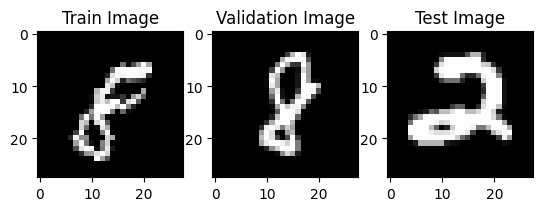

In [11]:
# Para recordar lo realizado hasta ahora, simplemente definimos algunos modelos de vision transformers y luego de definir las clases las probamos para corroborar que estaban funcionando correctamente, entonces haremos lo mismo para estos datasets, entonces tomaremos algunos datos y los dibujaremos
plt.figure()
f, axarr = plt.subplots(1, 3) # tomar una fila y colocar tres columnas para la validación y prueba del dataset

# lo que hace es que, como en el train en la primera columna tenemos las etiquetas pero no las queremos y solo tomaremos los pixeles entonces por eso "train_df.iloc[:, 1:]" y con "rain_df.iloc[:, 0]" tomamos la columna 0 porque ahí contiene los labels
train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0]) # tomar el índice 0 del dataset para saber que la función de obtener los elementos funciona
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray") # mostrar una imagen del dataset usando el índice 0 lo que significa que escribiremos en la columna 0 de nuestra subplot y decimos que estamos mostrando el dataset y tomamos la imagen en el índice 0 y seleccionamos la propiedad image de los objetos que estamos generando de "return {"image": image, "label": label, "index": index}" y luego comprimirla con ".squeeze()" porque nos dará un tamaño de fondo o un input channel pero no queremos esa entrada aquí entonces por eso básicamente la comprimimos y ya no obtenemos ese input channel y con 'cmap="gray"' le pondremos un fondo gris
axarr[0].set_title("Train Image")
print("-"*30) # colocar un separador

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray") # estamos usando ya la columna de la segunda posición "axarr[1]" de nuestro gráfico no como arriba que se usa la primera posición con "axarr[0]"
axarr[1].set_title("Validation Image")
print("-"*30)

# para el test, como en MNISTSubmitDataset se envia solo images e indicies, lo haremos sin el ".iloc[:, 1:]" porque en el test no tenemos que excluir la primera columna que son los labels porque ya consta de solo pixeles y podemos tomarlo tal como está, tampoco necesitamos los ".iloc[:, 0]" porque no tenemos etiquetas, solo necesitamos los índices
test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray") # estamos usando ya la columna de la tercera posición "axarr[2]" de nuestro gráfico no como arriba que se usa la segunda posición con "axarr[1]"
axarr[2].set_title("Test Image")
print("-"*30)

plt.show() # veremos que se ejecutó exitosamente y lo que nos muestra es la longitud de nuestro dataset y eso es lo que devuelve si especificamos un índice

In [12]:
# Vamos a definir los cargadores de datos (data loaders). Primero vamos a entrenar el data loader, los usaremos mientras entrenamos para iterar a través de los datos
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False) # en el dataset de pruebas no vamos a mezclar las imágenes como en el train_dataloader y val_dataloader

In [13]:
# Ahora es tiempo de pasar al bucle de entrenamiento (train loop)
# primero necesitamos una función de pérdida y usaremos "CrossEntropyLoss()"
criterion = nn.CrossEntropyLoss()
# también necesitamos un optimizador y si seguimos el paper usaron el optimizador Adam, entonces en este ejercicio también lo usaremos
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

# podemos estimar el tiempo de entrenamiento
start = timeit.default_timer()

# empezaremos las iteraciones y también le pasaremos dos parámetros más "position=0, leave=True" y lo que hará es que le pide a "tqdm" imprimir una nueva línea como barra de progreso cada vez que hacemos una nueva iteración, entonces en lugar de eso va a permanecer como una sola barra y simplemente se cargará
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train() # llamar al modelo de entrenamiento

    # necesitaremos etiquetas de entrenamiento y predicciones, entonces se almacenarán esas etiquetas y predicciones
    train_labels = []
    train_preds = []

    # la pérdida de ejecución comenzará en 0
    train_running_loss = 0

    # iteraremos a través de cada data loader
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device) # de los objetos que hemos retornado como "return {"image": image, "label": label, "index": index}" para colocarla luego en el dispositivo
        label = img_label["label"].type(torch.uint8).to(device) # de los objetos que hemos retornado como "return {"image": image, "label": label, "index": index}" para colocarla luego en el dispositivo
        y_pred = model(img) # para las predicciones lo haremos como si tomáramos el modelo y le pasamos la imagen como se hizo por ejemplo en los "print(model(x).shape)" en la parte de "model(x)"
        y_pred_label = torch.argmax(y_pred, dim=1) # obtener la etiqueta prevista/predicha que vamos a hacer. Entonces lo que hace es como se hizo después de ejecutar el modelo con los datos dando como resultado el "torch.Size([512, 10])" donde el 512 es el tamaño de batch y el 10 es el número de clases y contiene la distribución de probabilidad, entonces esa distribución de probabilidad tiene el número más alto asignado al label predicho por lo que se desea tomar la columna con el número más alto de devolverla y eso será nuestra predicción y eso lo hacemos con "torch.argmax(y_pred, dim=1)" dándole una dimensión de 1 que es el "dim=1". Es decir, es como que digamos que 512 imágenes vinieron en el "y_pred" y tendrán 10 columnas donde cada una será para 10 clases y tenemos que obtener la probabilidad asignada más alta

        # ahora las agregaremos a las train labels y como las extenderemos entonces usaremos la CPU cuando las almacenemos porque si las almacena como CPU en la GPU entonces se agotará la memoria y con esto solo se usará la GPU para almacenar lo necesario entonces por eso es que se almacena en la CPU
        train_labels.extend(label.cpu().detach())
        # almacenaremos las predicciones y haremos el mismo procedimiento de arriba
        train_preds.extend(y_pred_label.cpu().detach())

        # actualizaremos la pérdida usando la función de pérdida
        loss = criterion(y_pred, label)

        # ahora es el momento de asegurarnos de que se esté aprendiendo y para eso lo que tenemos que hacer es la optimización. Estas tres líneas de código garantiza que se produzca el aprendizaje
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # después de lo anterior necesitamos actualizar nuestra pérdida para que la pérdida en funcionamiento del entrenamiento sea igual a la pérdida del elemento. Entonces se va actualizando en cada iteración del data loader de entrenamiento. Este train_running_loss almacena la pérdida de todas las partes y simplemente las suma y las almacena
        train_running_loss += loss.item()
    # aquí vamos a actualizar el val_loss para toda la época y por eso hacemos que el train_loss sea igual a la pérdida de funcionamiento (train_running_loss) dividida por el índice + 1. Este train_loss lo vamos almacenando simplemente como una pérdida por época
    train_loss = train_running_loss / (idx + 1) # esto es la pérdida para el entrenamiento

    # ahora haremos lo mismo para la parte de la validación, es muy similar a lo del entrenamieto. Primero llevamos el modelo al modo de evaluación
    model.eval()
    val_labels = [] # etiquetas de validación que almacenarán los datos de las etiquetas de validación
    val_preds = [] # predicciones de validación que almacenarán los datos de las predicciones de validación
    val_running_loss = 0 # pérdida de ejecución de validación que almacenará la pérdida de ejecución para su validación iniciará con 0

    # con "torch.no_grad()" se asegura de que no se produzca ningún aprendizaje aquí por lo que solo estamos tratando de obtener el puntaje de validación con el modelo de entrenamiento y por eso no queremos que ocurra ningún aprendizaje
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            # ahora tomamos la pérdida con la función de pérdida creada anteriormente pasándome la predicción y la etiqueta
            loss = criterion(y_pred, label)
            # actualizamos el val_running_loss (pérdida de ejecución de la validación) que será igual a la suma de cada pérdida del elemento
            val_running_loss += loss.item()
    # actualizamos la pérdida de la validación de la época
    val_loss = val_running_loss / (idx + 1)

    # con lo anterior entonces ahora el entrenamiento y la validación se completan uno encima de otro, aquí lo vamos a imprimir a medida que sucede el entrenamiento
    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}") # x sería la predicción y la y sería el label, si x e y son iguales entonces encontramos una predicción correcta
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

# finalizar la estimación del tiempo de entrenamiento
stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s") # mostrar la estimación del tiempo de entrenamiento

# al finalizar todo, veremos que nuestro entrenamiento está completo, veremos los resultado y la precisión para el entrenamiento es de 0.9199 y la precisión para la validación es de 0.9390 para las 40 épocas y la estimación del tiempo de entrenamiento es de 875.37 segundos que son aproximadamente 14.5895 minutos

100%|██████████| 9/9 [00:00<00:00,  9.39it/s]


------------------------------
Train Loss EPOCH 1: 2.2573
Valid Loss EPOCH 1: 2.0988


  2%|▎         | 1/40 [00:22<14:37, 22.51s/it]

Train Accuracy EPOCH 1: 0.1613
Valid Accuracy EPOCH 1: 0.2433
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.61it/s]


------------------------------
Train Loss EPOCH 2: 2.0112
Valid Loss EPOCH 2: 1.8102


  5%|▌         | 2/40 [00:44<14:00, 22.12s/it]

Train Accuracy EPOCH 2: 0.2700
Valid Accuracy EPOCH 2: 0.3729
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.20it/s]


------------------------------
Train Loss EPOCH 3: 1.6986
Valid Loss EPOCH 3: 1.5179


  8%|▊         | 3/40 [01:05<13:29, 21.88s/it]

Train Accuracy EPOCH 3: 0.4236
Valid Accuracy EPOCH 3: 0.5038
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.60it/s]


------------------------------
Train Loss EPOCH 4: 1.5197
Valid Loss EPOCH 4: 1.3830


 10%|█         | 4/40 [01:28<13:10, 21.97s/it]

Train Accuracy EPOCH 4: 0.5010
Valid Accuracy EPOCH 4: 0.5771
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.25it/s]


------------------------------
Train Loss EPOCH 5: 1.3998
Valid Loss EPOCH 5: 1.2657


 12%|█▎        | 5/40 [01:50<12:50, 22.00s/it]

Train Accuracy EPOCH 5: 0.5541
Valid Accuracy EPOCH 5: 0.6264
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.74it/s]


------------------------------
Train Loss EPOCH 6: 1.2811
Valid Loss EPOCH 6: 1.1353


 15%|█▌        | 6/40 [02:11<12:19, 21.76s/it]

Train Accuracy EPOCH 6: 0.6130
Valid Accuracy EPOCH 6: 0.6800
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.07it/s]


------------------------------
Train Loss EPOCH 7: 1.1658
Valid Loss EPOCH 7: 1.0387


 18%|█▊        | 7/40 [02:33<12:02, 21.91s/it]

Train Accuracy EPOCH 7: 0.6716
Valid Accuracy EPOCH 7: 0.7319
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.13it/s]


------------------------------
Train Loss EPOCH 8: 1.0595
Valid Loss EPOCH 8: 0.9497


 20%|██        | 8/40 [02:55<11:42, 21.95s/it]

Train Accuracy EPOCH 8: 0.7136
Valid Accuracy EPOCH 8: 0.7600
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.87it/s]


------------------------------
Train Loss EPOCH 9: 0.9742
Valid Loss EPOCH 9: 0.8459


 22%|██▎       | 9/40 [03:16<11:13, 21.73s/it]

Train Accuracy EPOCH 9: 0.7418
Valid Accuracy EPOCH 9: 0.7940
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.74it/s]


------------------------------
Train Loss EPOCH 10: 0.8967
Valid Loss EPOCH 10: 0.8006


 25%|██▌       | 10/40 [03:38<10:55, 21.84s/it]

Train Accuracy EPOCH 10: 0.7628
Valid Accuracy EPOCH 10: 0.8017
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.44it/s]


------------------------------
Train Loss EPOCH 11: 0.8424
Valid Loss EPOCH 11: 0.7398


 28%|██▊       | 11/40 [04:01<10:36, 21.94s/it]

Train Accuracy EPOCH 11: 0.7780
Valid Accuracy EPOCH 11: 0.8200
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.09it/s]


------------------------------
Train Loss EPOCH 12: 0.7984
Valid Loss EPOCH 12: 0.7055


 30%|███       | 12/40 [04:22<10:10, 21.82s/it]

Train Accuracy EPOCH 12: 0.7895
Valid Accuracy EPOCH 12: 0.8274
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.03it/s]


------------------------------
Train Loss EPOCH 13: 0.7550
Valid Loss EPOCH 13: 0.6917


 32%|███▎      | 13/40 [04:44<09:51, 21.90s/it]

Train Accuracy EPOCH 13: 0.8005
Valid Accuracy EPOCH 13: 0.8298
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.71it/s]


------------------------------
Train Loss EPOCH 14: 0.7213
Valid Loss EPOCH 14: 0.6298


 35%|███▌      | 14/40 [05:06<09:30, 21.93s/it]

Train Accuracy EPOCH 14: 0.8096
Valid Accuracy EPOCH 14: 0.8410
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.07it/s]


------------------------------
Train Loss EPOCH 15: 0.6693
Valid Loss EPOCH 15: 0.5771


 38%|███▊      | 15/40 [05:28<09:08, 21.96s/it]

Train Accuracy EPOCH 15: 0.8272
Valid Accuracy EPOCH 15: 0.8650
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.36it/s]


------------------------------
Train Loss EPOCH 16: 0.6450
Valid Loss EPOCH 16: 0.5558


 40%|████      | 16/40 [05:50<08:47, 21.97s/it]

Train Accuracy EPOCH 16: 0.8329
Valid Accuracy EPOCH 16: 0.8743
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.23it/s]


------------------------------
Train Loss EPOCH 17: 0.6115
Valid Loss EPOCH 17: 0.5563


 42%|████▎     | 17/40 [06:13<08:28, 22.10s/it]

Train Accuracy EPOCH 17: 0.8410
Valid Accuracy EPOCH 17: 0.8631
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.64it/s]


------------------------------
Train Loss EPOCH 18: 0.5786
Valid Loss EPOCH 18: 0.5151


 45%|████▌     | 18/40 [06:35<08:07, 22.16s/it]

Train Accuracy EPOCH 18: 0.8502
Valid Accuracy EPOCH 18: 0.8745
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.18it/s]


------------------------------
Train Loss EPOCH 19: 0.5562
Valid Loss EPOCH 19: 0.4837


 48%|████▊     | 19/40 [06:57<07:42, 22.00s/it]

Train Accuracy EPOCH 19: 0.8557
Valid Accuracy EPOCH 19: 0.8914
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.44it/s]


------------------------------
Train Loss EPOCH 20: 0.5278
Valid Loss EPOCH 20: 0.4370


 50%|█████     | 20/40 [07:19<07:20, 22.03s/it]

Train Accuracy EPOCH 20: 0.8628
Valid Accuracy EPOCH 20: 0.9012
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.43it/s]


------------------------------
Train Loss EPOCH 21: 0.5041
Valid Loss EPOCH 21: 0.4229


 52%|█████▎    | 21/40 [07:41<06:59, 22.06s/it]

Train Accuracy EPOCH 21: 0.8696
Valid Accuracy EPOCH 21: 0.9014
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.23it/s]


------------------------------
Train Loss EPOCH 22: 0.4914
Valid Loss EPOCH 22: 0.4246


 55%|█████▌    | 22/40 [08:02<06:34, 21.90s/it]

Train Accuracy EPOCH 22: 0.8727
Valid Accuracy EPOCH 22: 0.8955
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.96it/s]


------------------------------
Train Loss EPOCH 23: 0.4605
Valid Loss EPOCH 23: 0.3953


 57%|█████▊    | 23/40 [08:24<06:09, 21.74s/it]

Train Accuracy EPOCH 23: 0.8813
Valid Accuracy EPOCH 23: 0.9090
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.03it/s]


------------------------------
Train Loss EPOCH 24: 0.4448
Valid Loss EPOCH 24: 0.3945


 60%|██████    | 24/40 [08:45<05:47, 21.70s/it]

Train Accuracy EPOCH 24: 0.8832
Valid Accuracy EPOCH 24: 0.9052
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.93it/s]


------------------------------
Train Loss EPOCH 25: 0.4260
Valid Loss EPOCH 25: 0.3875


 62%|██████▎   | 25/40 [09:07<05:25, 21.73s/it]

Train Accuracy EPOCH 25: 0.8884
Valid Accuracy EPOCH 25: 0.9019
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.92it/s]


------------------------------
Train Loss EPOCH 26: 0.4126
Valid Loss EPOCH 26: 0.3690


 65%|██████▌   | 26/40 [09:28<05:01, 21.54s/it]

Train Accuracy EPOCH 26: 0.8906
Valid Accuracy EPOCH 26: 0.9064
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.85it/s]


------------------------------
Train Loss EPOCH 27: 0.3986
Valid Loss EPOCH 27: 0.3185


 68%|██████▊   | 27/40 [09:50<04:40, 21.59s/it]

Train Accuracy EPOCH 27: 0.8935
Valid Accuracy EPOCH 27: 0.9202
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.48it/s]


------------------------------
Train Loss EPOCH 28: 0.3835
Valid Loss EPOCH 28: 0.3205


 70%|███████   | 28/40 [10:12<04:19, 21.66s/it]

Train Accuracy EPOCH 28: 0.8962
Valid Accuracy EPOCH 28: 0.9226
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.74it/s]


------------------------------
Train Loss EPOCH 29: 0.3693
Valid Loss EPOCH 29: 0.3488


 72%|███████▎  | 29/40 [10:33<03:56, 21.51s/it]

Train Accuracy EPOCH 29: 0.9014
Valid Accuracy EPOCH 29: 0.9076
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.88it/s]


------------------------------
Train Loss EPOCH 30: 0.3617
Valid Loss EPOCH 30: 0.3024


 75%|███████▌  | 30/40 [10:55<03:35, 21.58s/it]

Train Accuracy EPOCH 30: 0.9026
Valid Accuracy EPOCH 30: 0.9210
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.15it/s]


------------------------------
Train Loss EPOCH 31: 0.3558
Valid Loss EPOCH 31: 0.2952


 78%|███████▊  | 31/40 [11:17<03:15, 21.69s/it]

Train Accuracy EPOCH 31: 0.9023
Valid Accuracy EPOCH 31: 0.9205
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.15it/s]


------------------------------
Train Loss EPOCH 32: 0.3418
Valid Loss EPOCH 32: 0.2766


 80%|████████  | 32/40 [11:38<02:53, 21.71s/it]

Train Accuracy EPOCH 32: 0.9069
Valid Accuracy EPOCH 32: 0.9264
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.80it/s]


------------------------------
Train Loss EPOCH 33: 0.3376
Valid Loss EPOCH 33: 0.2739


 82%|████████▎ | 33/40 [12:01<02:33, 21.89s/it]

Train Accuracy EPOCH 33: 0.9074
Valid Accuracy EPOCH 33: 0.9317
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.58it/s]


------------------------------
Train Loss EPOCH 34: 0.3202
Valid Loss EPOCH 34: 0.2799


 85%|████████▌ | 34/40 [12:23<02:11, 21.94s/it]

Train Accuracy EPOCH 34: 0.9113
Valid Accuracy EPOCH 34: 0.9319
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.07it/s]


------------------------------
Train Loss EPOCH 35: 0.3186
Valid Loss EPOCH 35: 0.2630


 88%|████████▊ | 35/40 [12:45<01:50, 22.01s/it]

Train Accuracy EPOCH 35: 0.9116
Valid Accuracy EPOCH 35: 0.9307
------------------------------


100%|██████████| 9/9 [00:00<00:00, 12.13it/s]


------------------------------
Train Loss EPOCH 36: 0.3094
Valid Loss EPOCH 36: 0.2670


 90%|█████████ | 36/40 [13:06<01:27, 21.86s/it]

Train Accuracy EPOCH 36: 0.9131
Valid Accuracy EPOCH 36: 0.9281
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.23it/s]


------------------------------
Train Loss EPOCH 37: 0.2906
Valid Loss EPOCH 37: 0.2629


 92%|█████████▎| 37/40 [13:29<01:06, 22.05s/it]

Train Accuracy EPOCH 37: 0.9183
Valid Accuracy EPOCH 37: 0.9302
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.34it/s]


------------------------------
Train Loss EPOCH 38: 0.2862
Valid Loss EPOCH 38: 0.2338


 95%|█████████▌| 38/40 [13:51<00:44, 22.07s/it]

Train Accuracy EPOCH 38: 0.9193
Valid Accuracy EPOCH 38: 0.9402
------------------------------


100%|██████████| 9/9 [00:01<00:00,  7.56it/s]


------------------------------
Train Loss EPOCH 39: 0.2857
Valid Loss EPOCH 39: 0.2381


 98%|█████████▊| 39/40 [14:13<00:22, 22.17s/it]

Train Accuracy EPOCH 39: 0.9194
Valid Accuracy EPOCH 39: 0.9374
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.95it/s]


------------------------------
Train Loss EPOCH 40: 0.2824
Valid Loss EPOCH 40: 0.2436


100%|██████████| 40/40 [14:35<00:00, 21.88s/it]

Train Accuracy EPOCH 40: 0.9199
Valid Accuracy EPOCH 40: 0.9390
------------------------------
Training Time: 875.37s


In [14]:
# ahora lo que haremos es abrir un cache vacío lo que nos ayuda a cargar algunas cosas desde la memoria como el modelo, las imágenes, etc por si se tiene la memoria GPU casi llena y por eso antes de continuar con el siguiente bloque de código entonces tenemos que descargar o vaciar la memoria usando "torch.cuda.empty_cache()"
torch.cuda.empty_cache()

In [15]:
# ahora vamos a continuar con las predicciones y como tenemos un data loader de prueba, entonces comenzamos creando una lista para las labels, una lista para los id y una lista para las imágenes
labels = [] # lista de etiquetas
ids = [] # lista de los id
imgs = [] # lista de las imágenes

# ponemos el modelo en evaluación
model.eval()

 # con "torch.no_grad()" se asegura de que no se produzca ningún aprendizaje aquí por lo que solo estamos tratando de obtener el puntaje de validación con el modelo de entrenamiento y por eso no queremos que ocurra ningún aprendizaje
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]]) # almacenamos como entero extendido del índice como número y le sumamos 1 porque los archivos comienzan en 0 pero a sus índices se le agrega un 1

        # obtener los resultados que es igual al modelo de la imagen
        outputs = model(img)

        # aquí se extiende la imagen del modelo nuevamente, en esta extensión almacenamos las imágenes porque en realidad veremos las predicciones y las imágenes originales, primero las separamos y luego colocamos la CPU porque como se mencionó arriba no queremos tomar la memoria de la GPU
        imgs.extend(img.detach().cpu())
        # almacenamos también las labels y nuevamente queremos guardar las etiquetas como números enteros y con  torch.argmax(...) estamos seleccionando la probabilidad más alta
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████| 55/55 [00:05<00:00, 10.31it/s]


<Figure size 640x480 with 0 Axes>

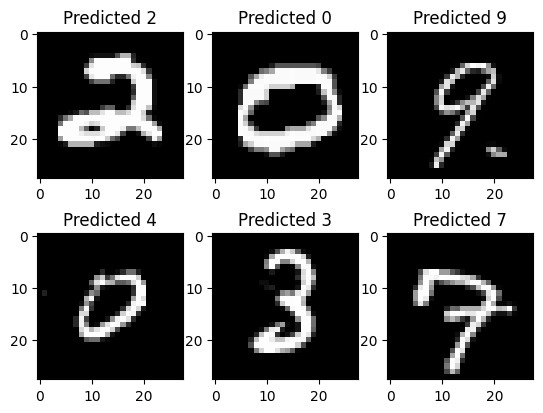

In [16]:
# ahora vamos a graficar algunos datos de prueba y veremos nuestras predicciones
plt.figure()
f, axarr = plt.subplots(2, 3) # tendremos un total de 6 imágenes por eso y por eso tendremos 2 filas y 3 columnas
counter = 0 # necesitaremos un counter o contador
# vamos a iterar sobre las 2 filas
for i in range(2):
    # vamos a iterar sobre las 3 columnas
    for j in range(3):
        # pondremos la imagen en cada fila y columna y lo mostraremos a partir de imágenes
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        # estableceremos un título y diremos el valor predicho que está en "labels[counter]"
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1 # actualizar el contador +1

plt.show()

In [ ]:
# si queremos continuar con la parte de submission y se guardará en el archivo de submission
submission_df = pd.DataFrame(list(zip(ids, labels)),
               columns =["ImageId", "Label"])
submission_df.to_csv("submission.csv", index=False)
submission_df.head()